## Reading Data

In [1]:
import os
import cv2

DATADIR = "Dataset"
CATEGORIES = ["flooded", "non-flooded"]
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        data.append(img_array)
        labels.append(CATEGORIES.index(category))
print(len(data))
print(labels.count(0))
print(labels.count(1))


922
461
461


## Preprocessing

In [2]:
import matplotlib.pyplot as plt

# get min width and height
min_width = 999999
min_height = 999999
for img in data:
    height, width, channels = img.shape
    if width < min_width:
        min_width = width
    if height < min_height:
        min_height = height
print(min_width)
print(min_height)



123
152


## Features Extraction

In [3]:
def extract_image_features(image):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (512 , 512))
    return image

data = [extract_image_features(image) for image in data]

## Splitting Data

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_val , y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)


## Model

### Model Building

In [5]:
# build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 253, 253, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     7

### Moddel Training

In [6]:
# train the model

X_train = X_train.reshape(X_train.shape[0] , 512, 512, 3)
X_val = X_val.reshape(X_val.shape[0], 512, 512, 3)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

#early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[model_checkpoint])


Epoch 1/20
24/24 [==============================] - 210s 9s/step - loss: 670.1356 - accuracy: 0.5550 - val_loss: 0.6868 - val_accuracy: 0.5297
Epoch 2/20
24/24 [==============================] - 193s 8s/step - loss: 0.6688 - accuracy: 0.6106 - val_loss: 0.6906 - val_accuracy: 0.5297
Epoch 3/20
24/24 [==============================] - 191s 8s/step - loss: 0.5950 - accuracy: 0.6431 - val_loss: 0.7234 - val_accuracy: 0.5730
Epoch 4/20
24/24 [==============================] - 189s 8s/step - loss: 0.8572 - accuracy: 0.6798 - val_loss: 0.7904 - val_accuracy: 0.5243
Epoch 5/20
24/24 [==============================] - 2629s 114s/step - loss: 0.4839 - accuracy: 0.7218 - val_loss: 0.7786 - val_accuracy: 0.5189
Epoch 6/20
24/24 [==============================] - 200s 8s/step - loss: 0.4175 - accuracy: 0.7395 - val_loss: 1.1071 - val_accuracy: 0.4811
Epoch 7/20
24/24 [==============================] - 211s 9s/step - loss: 0.3231 - accuracy: 0.8005 - val_loss: 1.7316 - val_accuracy: 0.4757
Epoch 8/

## Evaluation

6/6 [==============================] - 2s 351ms/step
F1 score:  0.4105960264900662


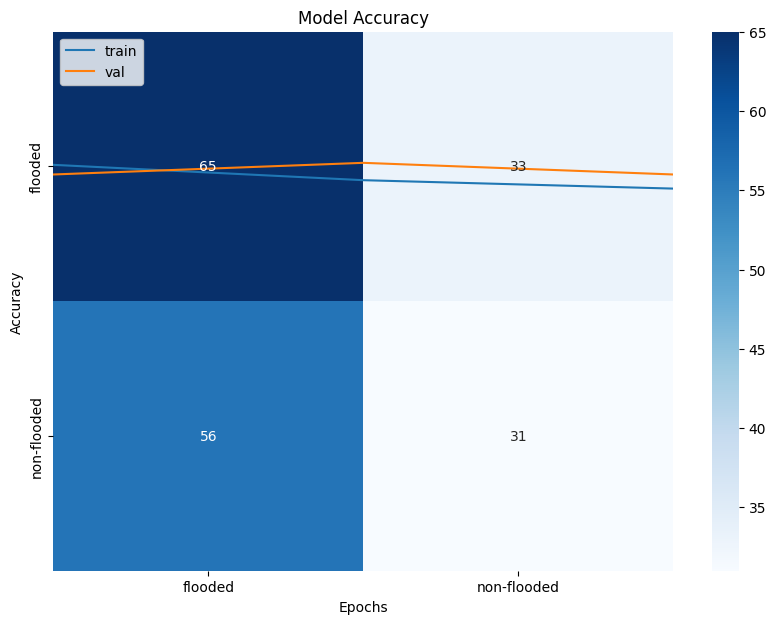

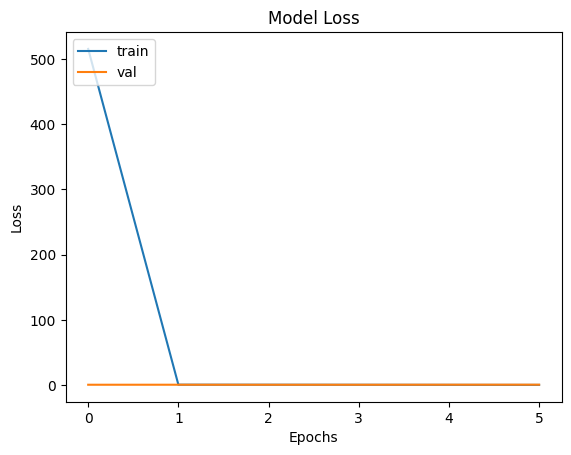

In [18]:
# Get confusion matrix , f1 score
# Plot confusion matrix

from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import pandas as pd

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in ["flooded", "non-flooded"]],
                    columns = [i for i in ["flooded", "non-flooded"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.show()
print("F1 score: ", f1_score(y_true, y_pred))

# Plot accuracy and loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save the model

model.save('model.h5')

# Load the model

from tensorflow.keras.models import load_model

model = load_model('model.h5')


